In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

# import from utils.ipynb
import ipynb.fs.full.utils as utils

# 1. Load raw input
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=7
currency_pair = 'EUR=X'
numbers_in_currency = 'EUR'
share_name = 'STERV.HE'

# 1.1 Calculate Share numbers from total distributed dividend (CFS) and dividend amount

# 1.2. Raw input statement data

In [3]:
route = f"../csv_files/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../csv_files/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2016-12-31,2438,-2028,410,56,953,1273,1346,3627,238,...,12326,0,4,552,2989,2655,6520,417,-220,788.6
1,2017-03-31,2497,-2045,452,107,932,1337,1438,3749,237,...,12384,0,8,821,3284,2334,6470,83,-135,788.6
2,2017-06-30,2528,-2092,436,143,499,1335,1351,3259,237,...,11590,0,4,395,2796,2315,5978,283,-128,788.6
3,2017-09-30,2509,-2013,496,191,418,1325,1331,3154,237,...,11470,0,5,389,2754,2092,5671,364,-138,788.6
4,2017-12-31,2511,-2066,445,173,607,1319,1321,3336,237,...,11770,0,4,370,2963,2046,5762,472,-257,788.6


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
24,2022-12-31,2023-02-11,788.6,2864,-2372,492,584,1917,1473,1810,...,244,20922,0,429,667,3697,2792,8390,364,-224
25,2023-03-31,2023-04-21,788.6,2721,-2304,417,185,1257,1463,1903,...,566,20288,0,504,917,4001,2864,8601,209,-253
26,2023-06-30,2023-07-21,788.6,2374,-2217,157,-257,1973,1304,1761,...,473,20078,0,561,450,3281,4088,9011,66,-215
27,2023-09-30,2023-10-21,788.6,2127,-1947,180,-34,2077,1258,1652,...,468,20226,0,580,489,3355,4182,9158,205,-193
28,2023-12-31,2024-02-11,788.6,2174,-2030,144,-325,2464,1191,1466,...,391,20754,0,418,286,3004,4446,9768,272,-328


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,788.6,2864,-2372,492,584,1917,1473,1810,...,20922,0,429,667,3697,2792,8390,364,-224,0.980663
25,2023-03-31,2023-04-21,788.6,2721,-2304,417,185,1257,1463,1903,...,20288,0,504,917,4001,2864,8601,209,-253,0.932003
26,2023-06-30,2023-07-21,788.6,2374,-2217,157,-257,1973,1304,1761,...,20078,0,561,450,3281,4088,9011,66,-215,0.918362
27,2023-09-30,2023-10-21,788.6,2127,-1947,180,-34,2077,1258,1652,...,20226,0,580,489,3355,4182,9158,205,-193,0.918837
28,2023-12-31,2024-02-11,788.6,2174,-2030,144,-325,2464,1191,1466,...,20754,0,418,286,3004,4446,9768,272,-328,0.929674


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
24,2022-12-31,2023-02-11,788.6,2864,-2372,492,584,1917,1473,1810,...,20922,0,429,667,3697,2792,8390,364,-224,0.980663
25,2023-03-31,2023-04-21,788.6,2721,-2304,417,185,1257,1463,1903,...,20288,0,504,917,4001,2864,8601,209,-253,0.932003
26,2023-06-30,2023-07-21,788.6,2374,-2217,157,-257,1973,1304,1761,...,20078,0,561,450,3281,4088,9011,66,-215,0.918362
27,2023-09-30,2023-10-21,788.6,2127,-1947,180,-34,2077,1258,1652,...,20226,0,580,489,3355,4182,9158,205,-193,0.918837
28,2023-12-31,2024-02-11,788.6,2174,-2030,144,-325,2464,1191,1466,...,20754,0,418,286,3004,4446,9768,272,-328,0.929674


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

## Calculate performance parameters (current ratio, ROA, ROE, margins, D/E)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2017-02-13,7.660887,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,0.471037,0.528963,7.660644,inf,10.232949,6.026746,0.168171,0.02297,0.018173,0.038581
1,2017-02-20,7.489318,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,0.471037,0.528963,7.660644,inf,10.232949,6.026746,0.168171,0.02297,0.018173,0.038581
2,2017-02-27,7.802617,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,0.471037,0.528963,7.660644,inf,10.232949,6.026746,0.168171,0.02297,0.018173,0.038581
3,2017-03-06,7.742942,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,0.471037,0.528963,7.660644,inf,10.232949,6.026746,0.168171,0.02297,0.018173,0.038581
4,2017-03-13,8.339701,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,0.471037,0.528963,7.660644,inf,10.232949,6.026746,0.168171,0.02297,0.018173,0.038581


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2017-02-13,7.660887,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,6.026746,0.168171,0.02297,0.018173,0.038581,26.970425,1.040540,0.619501,1.190358,2.371026
1,2017-02-20,7.489318,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,6.026746,0.168171,0.02297,0.018173,0.038581,26.366413,1.017237,0.605627,1.176484,2.317926
2,2017-02-27,7.802617,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,6.026746,0.168171,0.02297,0.018173,0.038581,27.469392,1.059791,0.630962,1.201820,2.414892
3,2017-03-06,7.742942,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,6.026746,0.168171,0.02297,0.018173,0.038581,27.259305,1.051685,0.626137,1.196994,2.396422
4,2017-03-13,8.339701,2016-12-31,2438.0,0.284048,7.362414,788.6,2548.0,3.231042,953.0,...,6.026746,0.168171,0.02297,0.018173,0.038581,29.360214,1.132740,0.674394,1.245251,2.581118


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

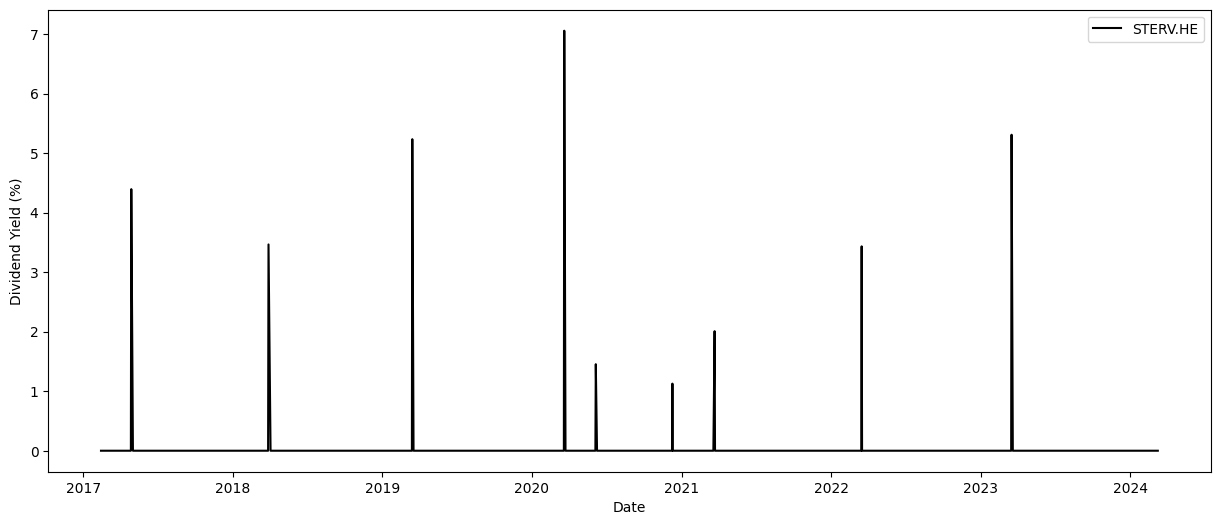

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate   -0.000157
share_price      1.000000
Name: share_price, dtype: float64


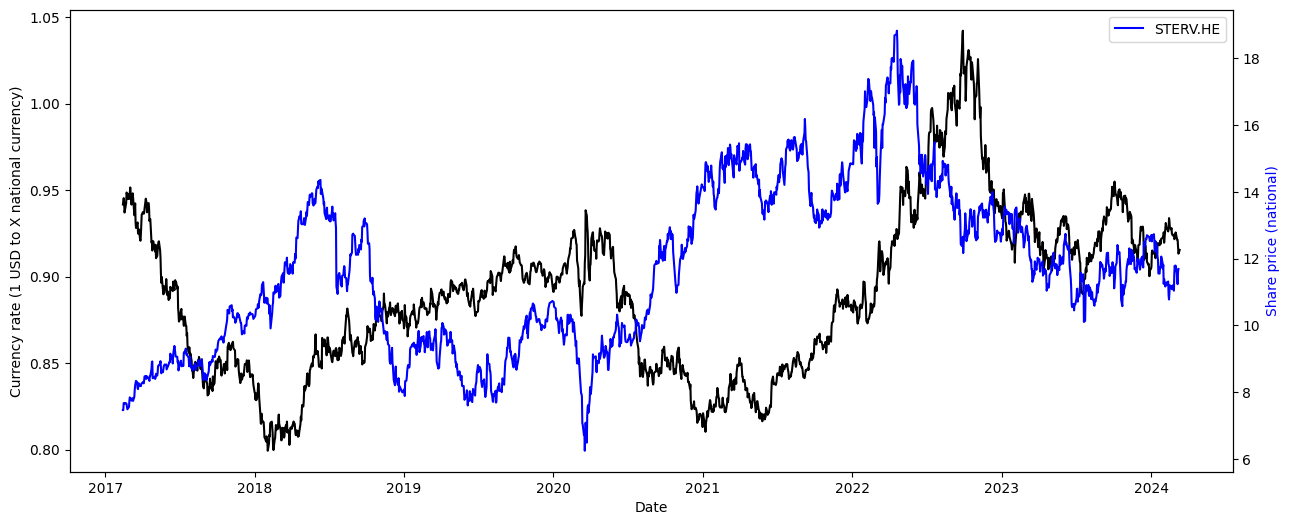

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

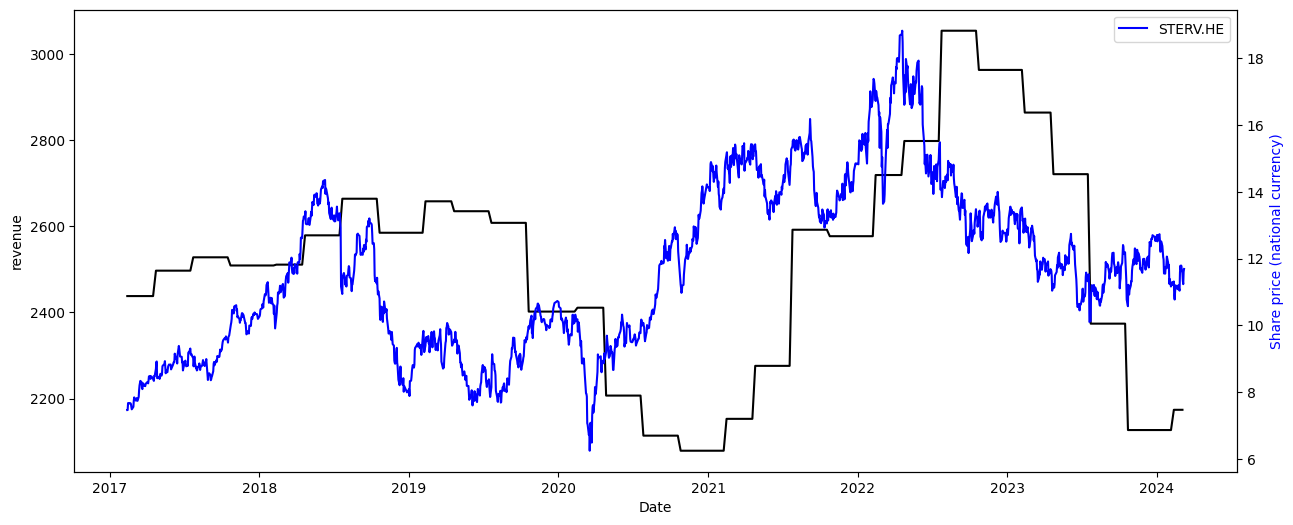

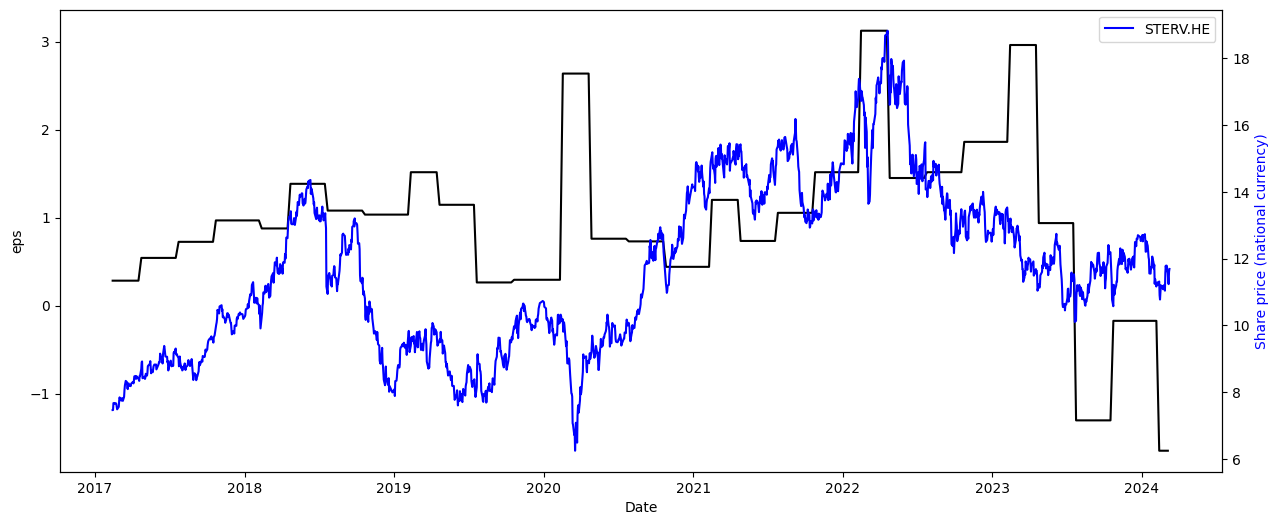

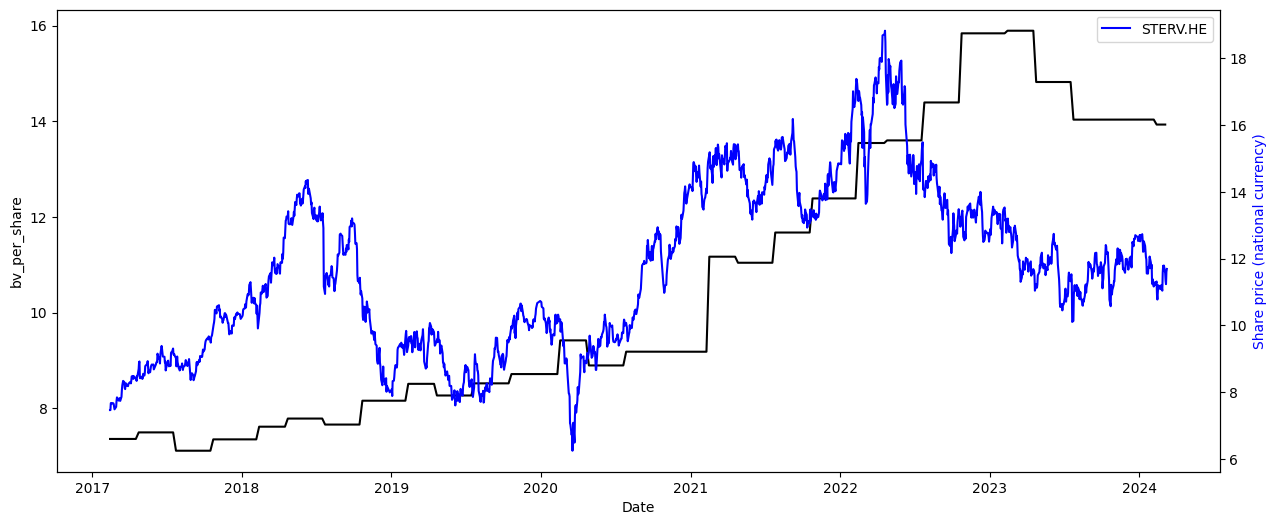

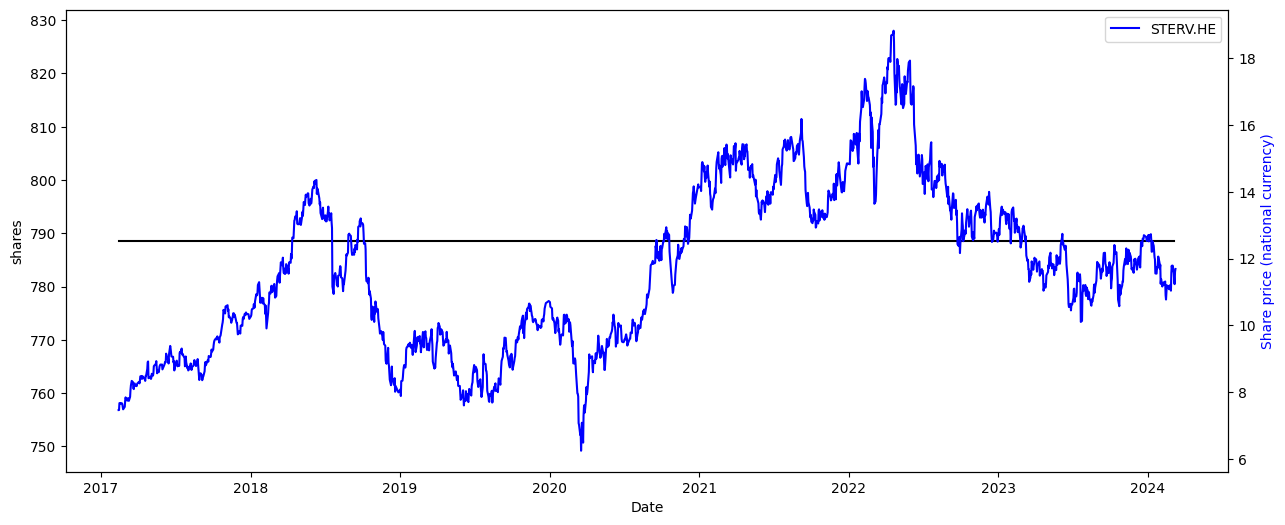

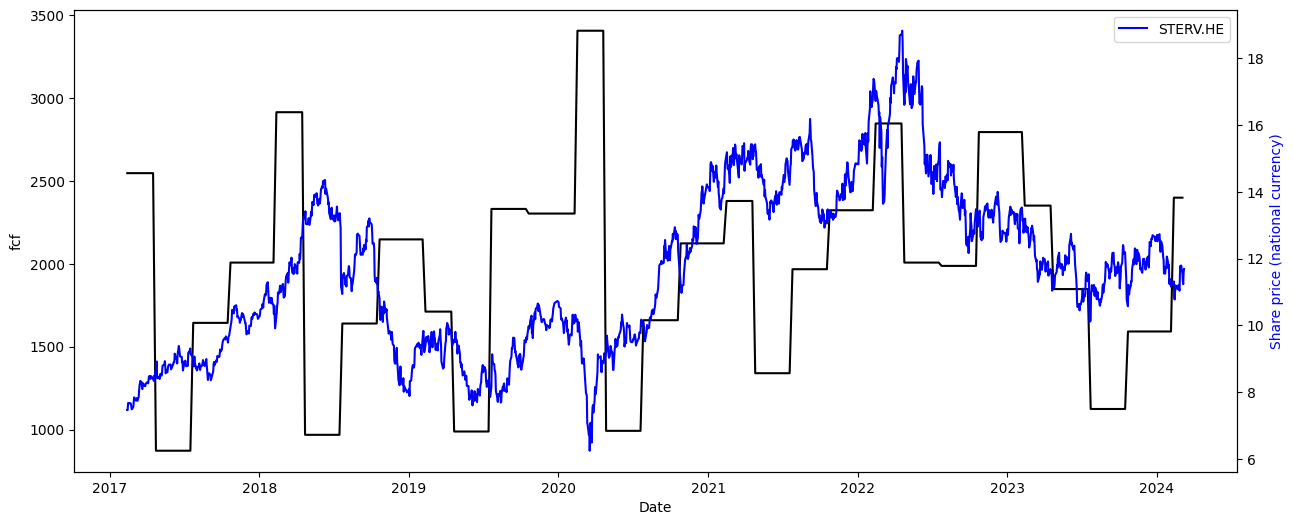

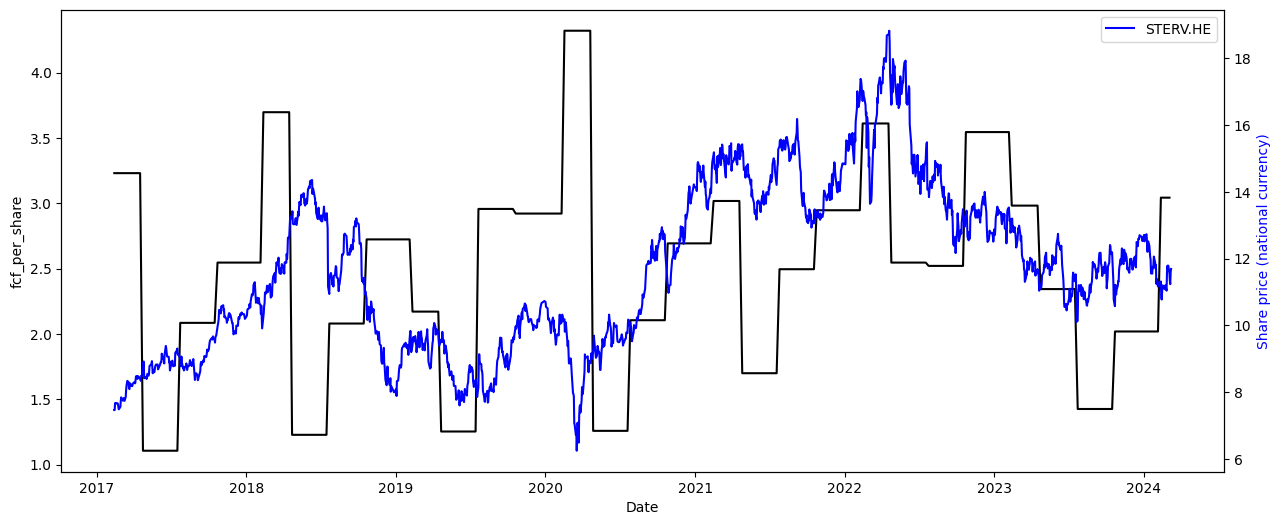

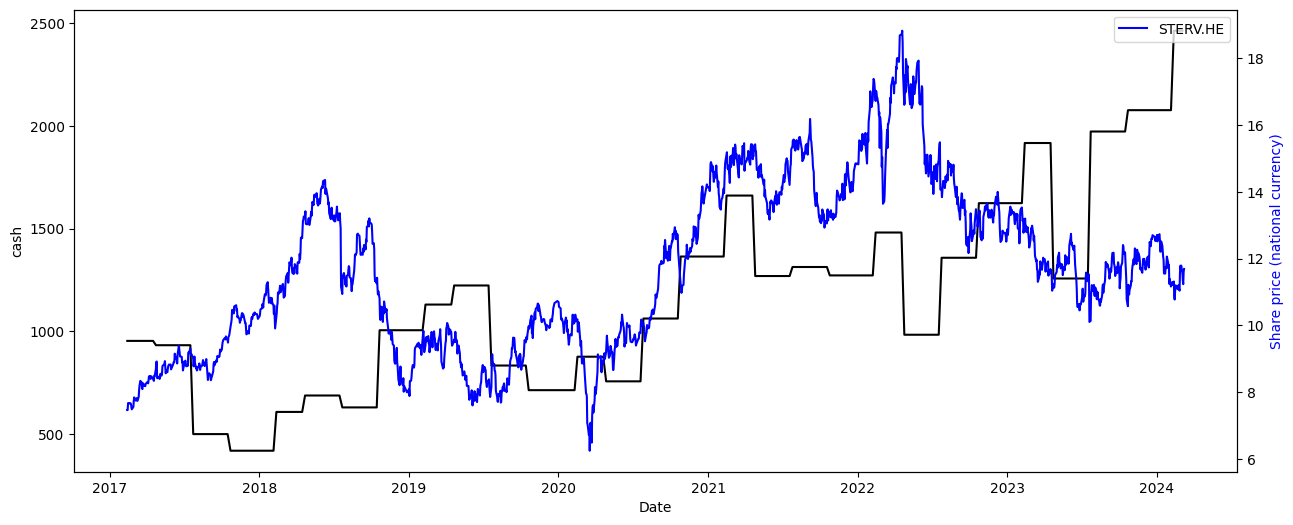

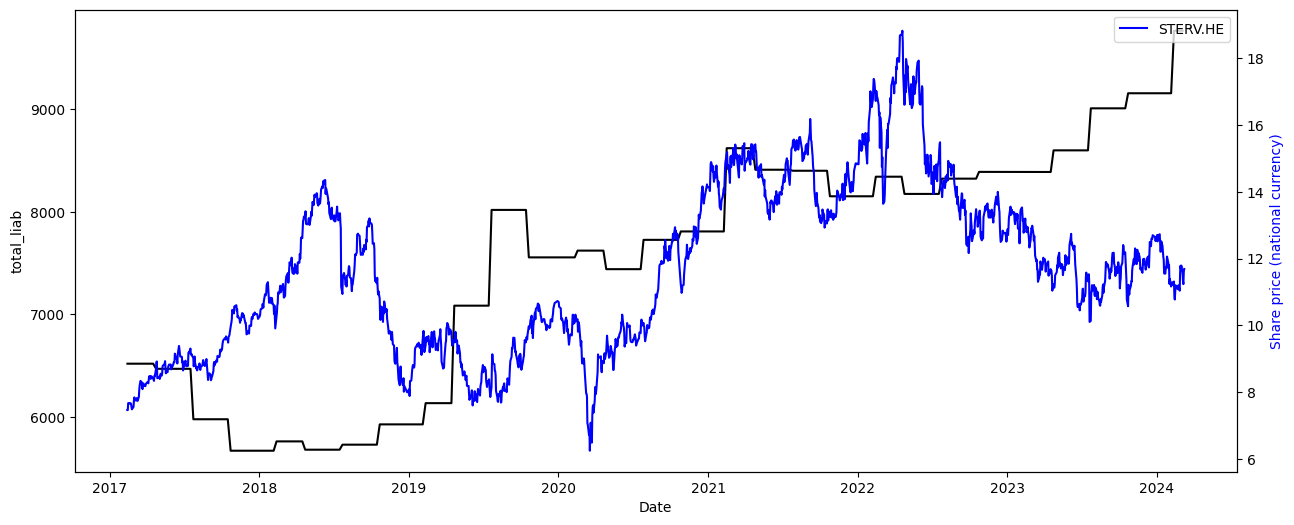

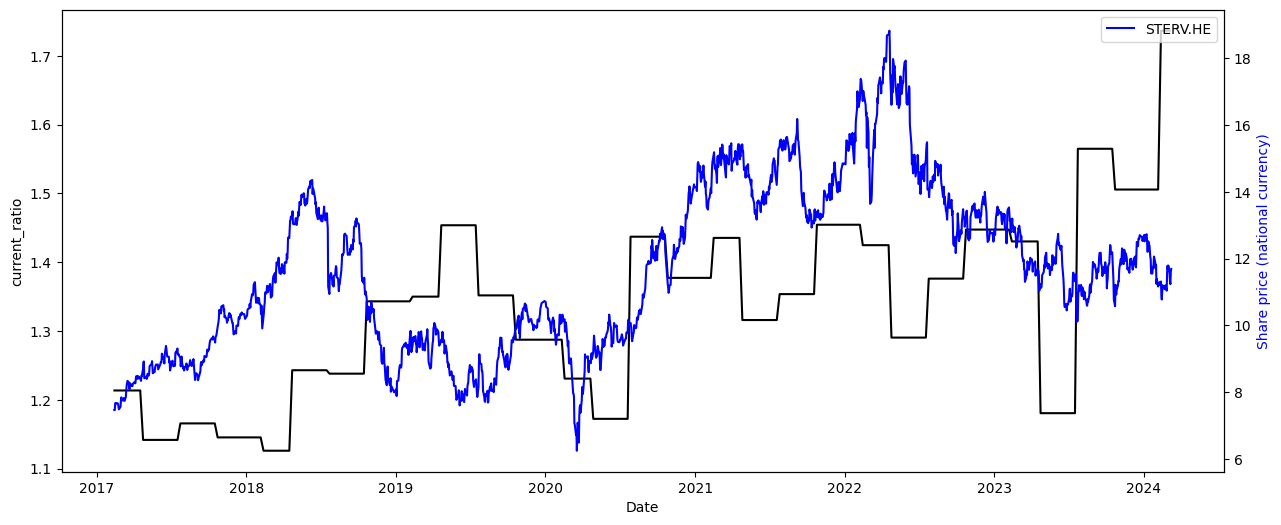

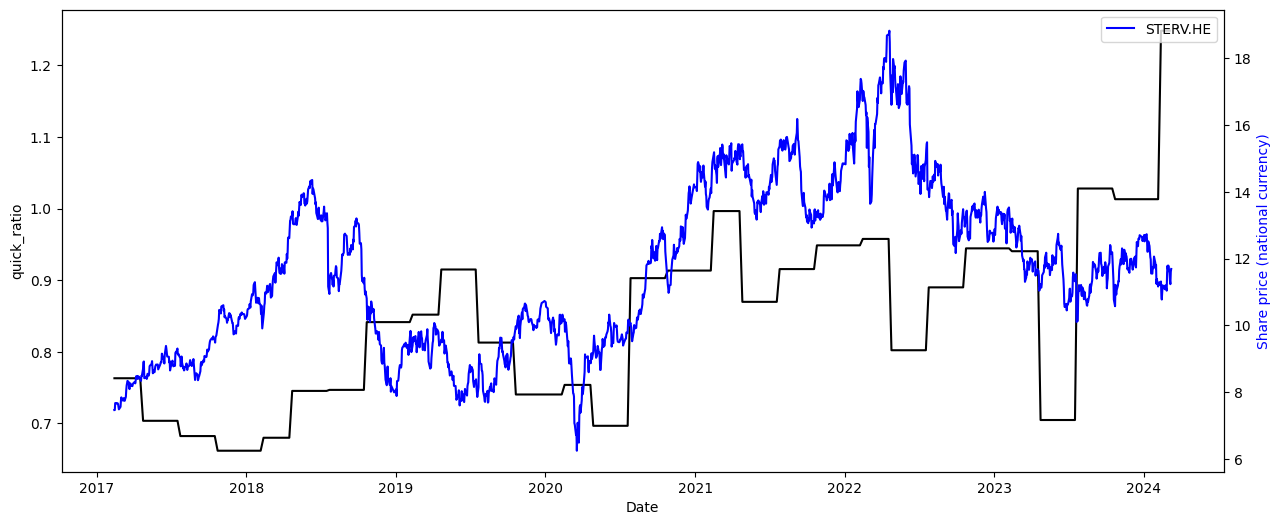

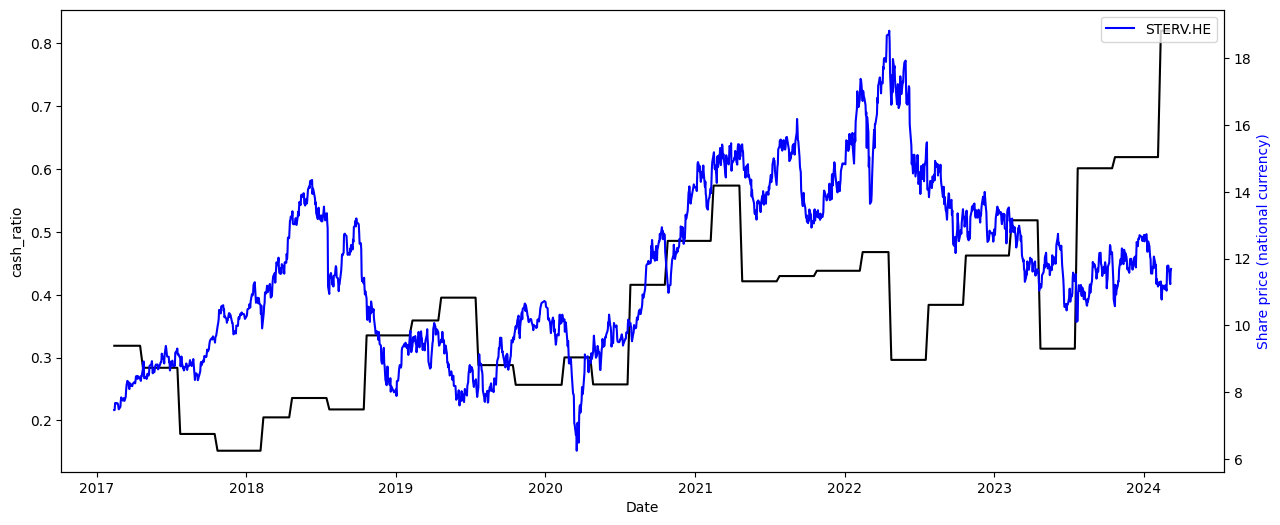

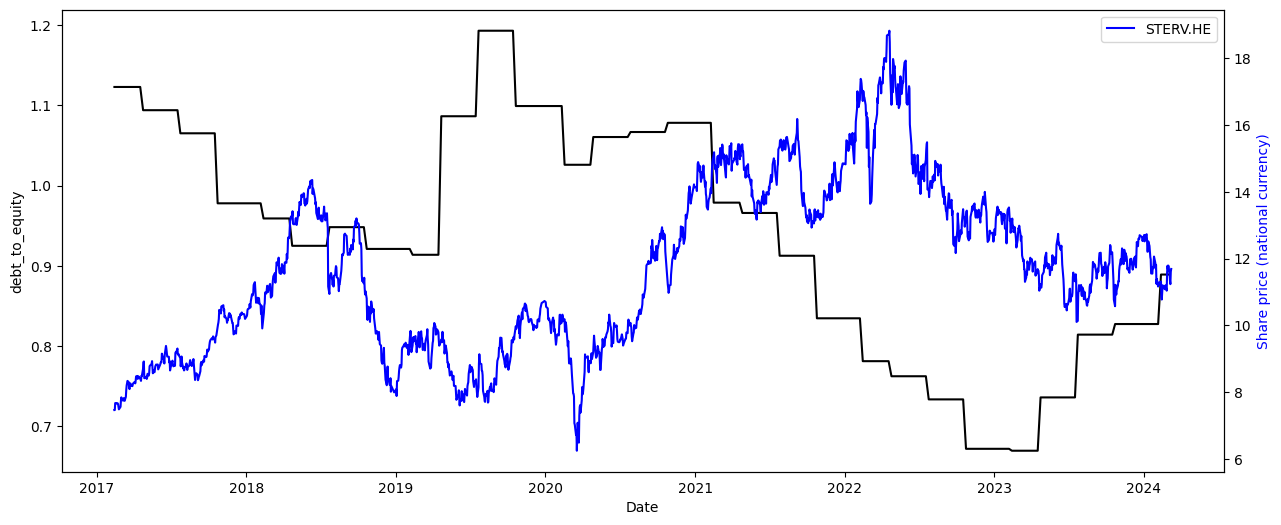

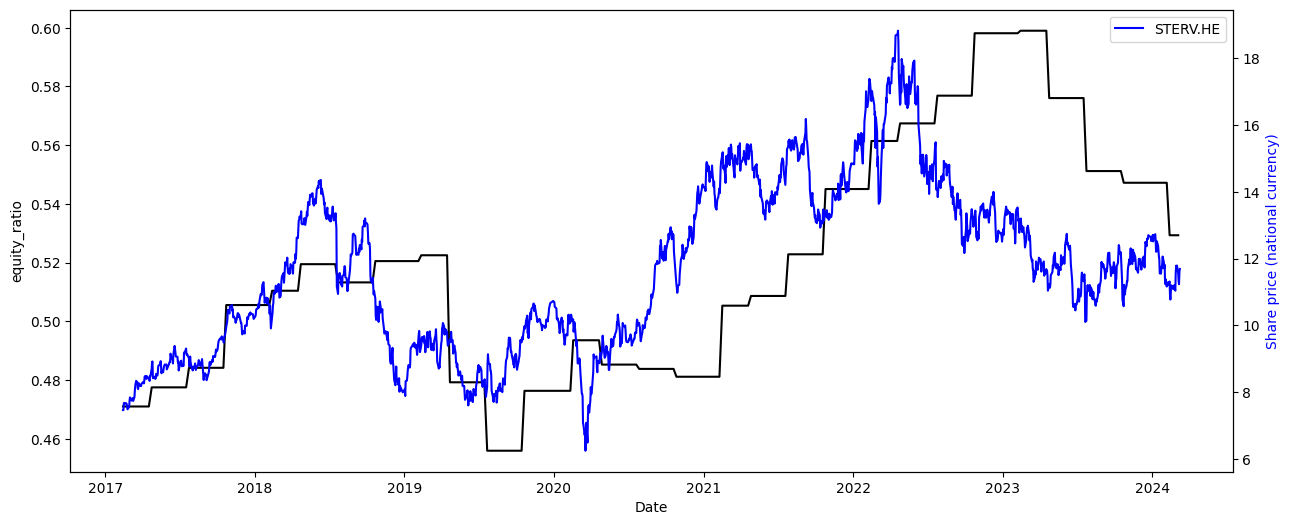

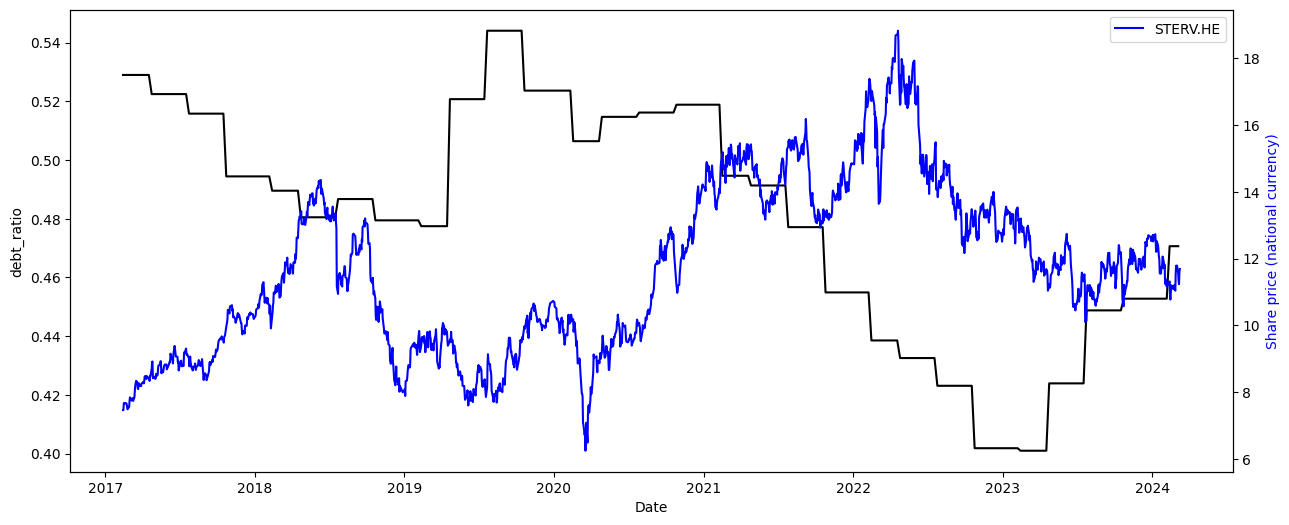

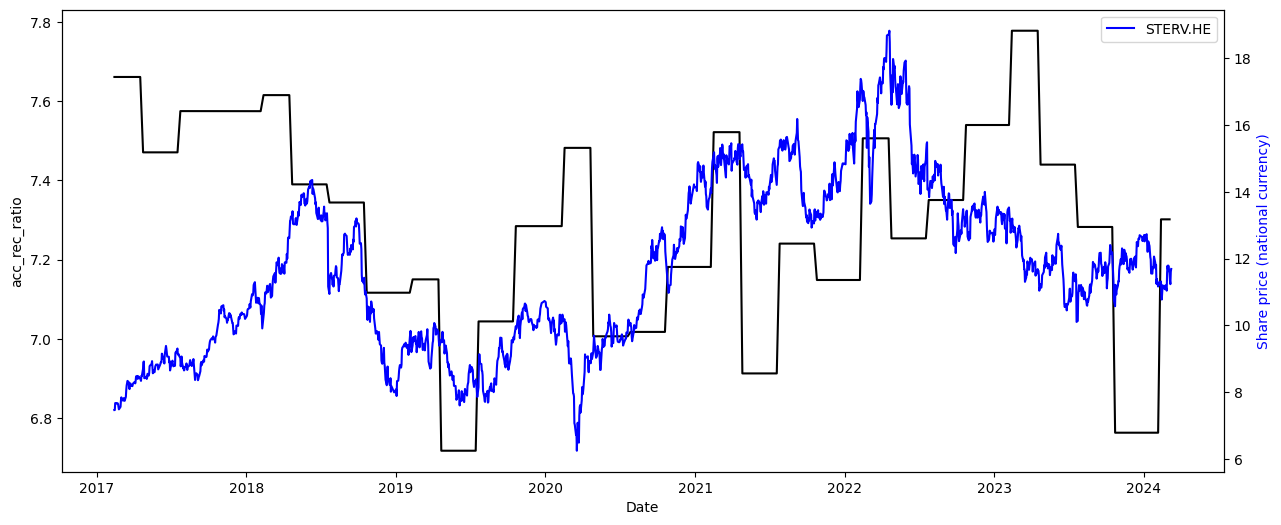

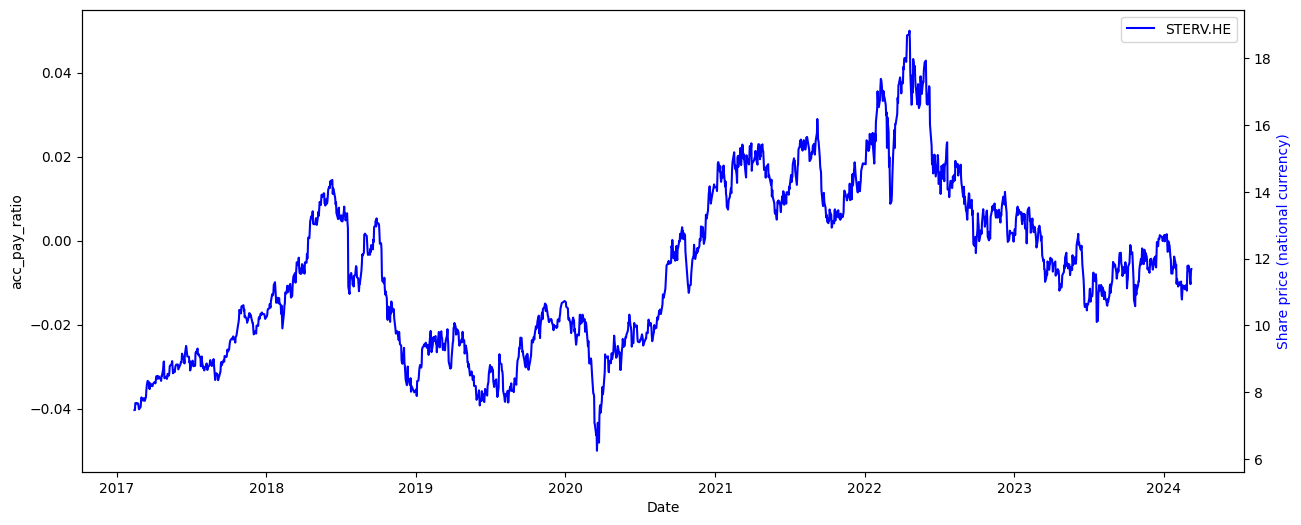

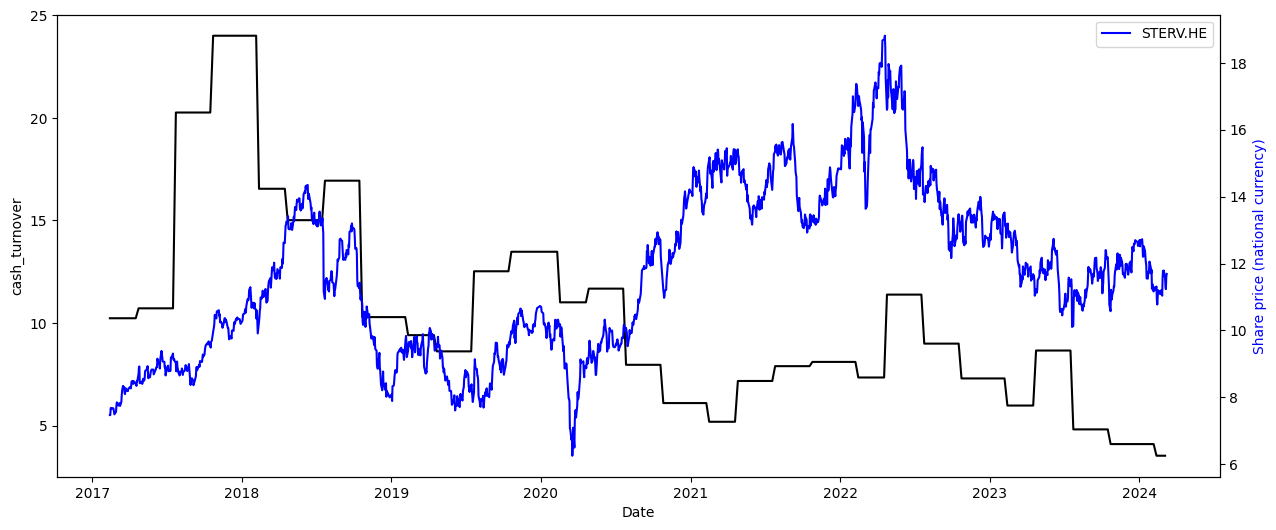

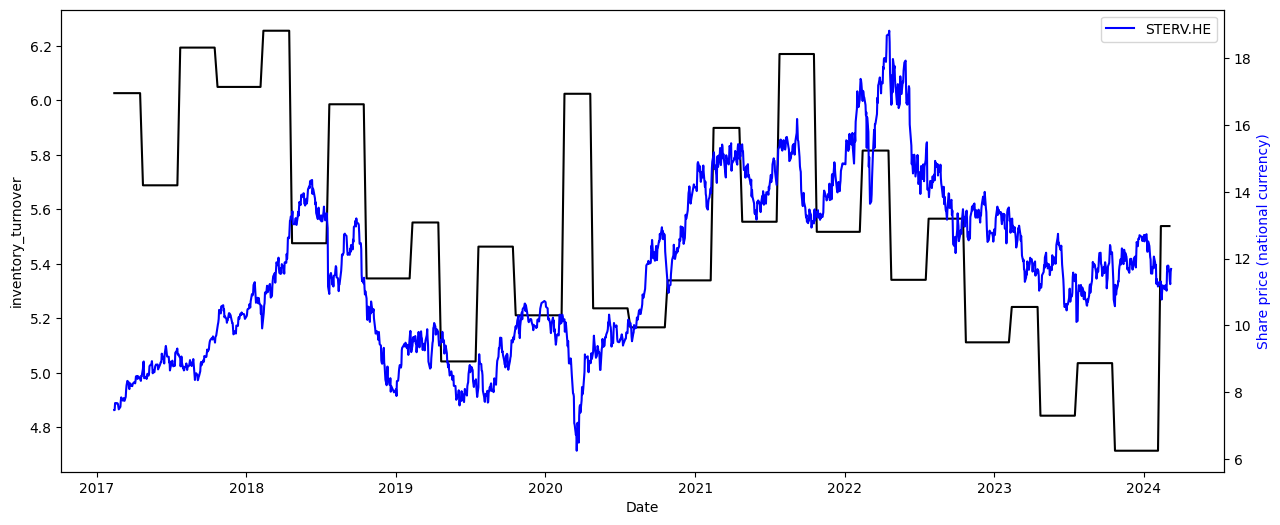

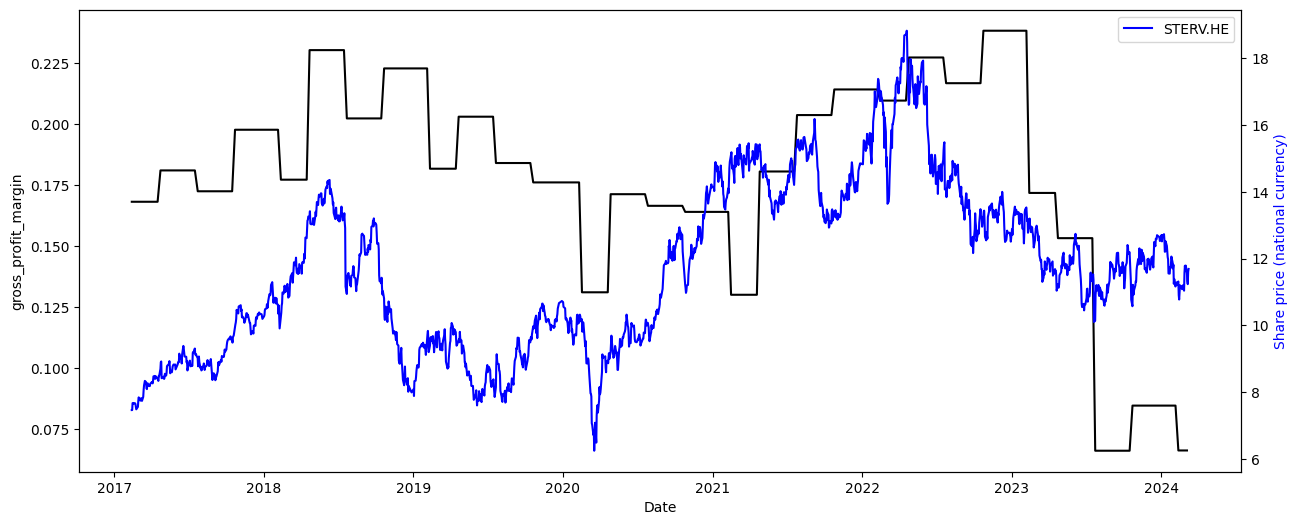

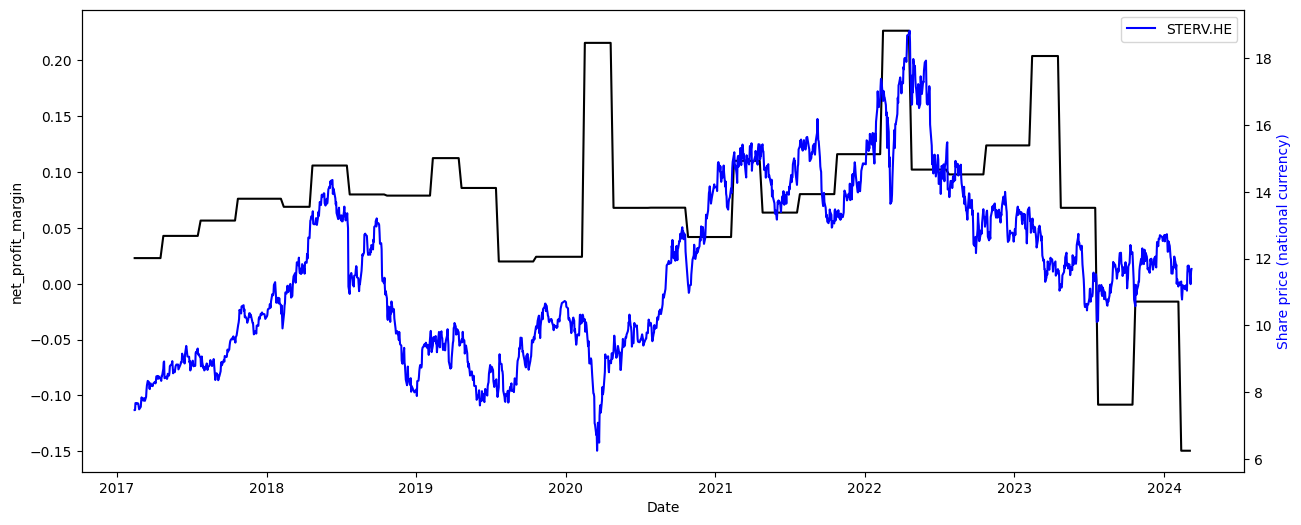

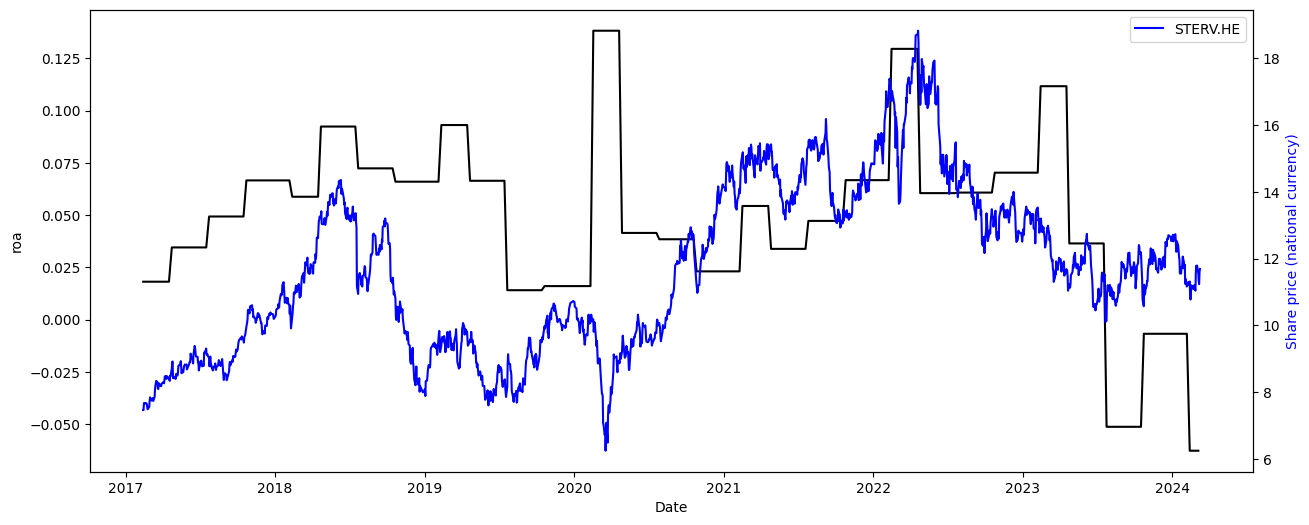

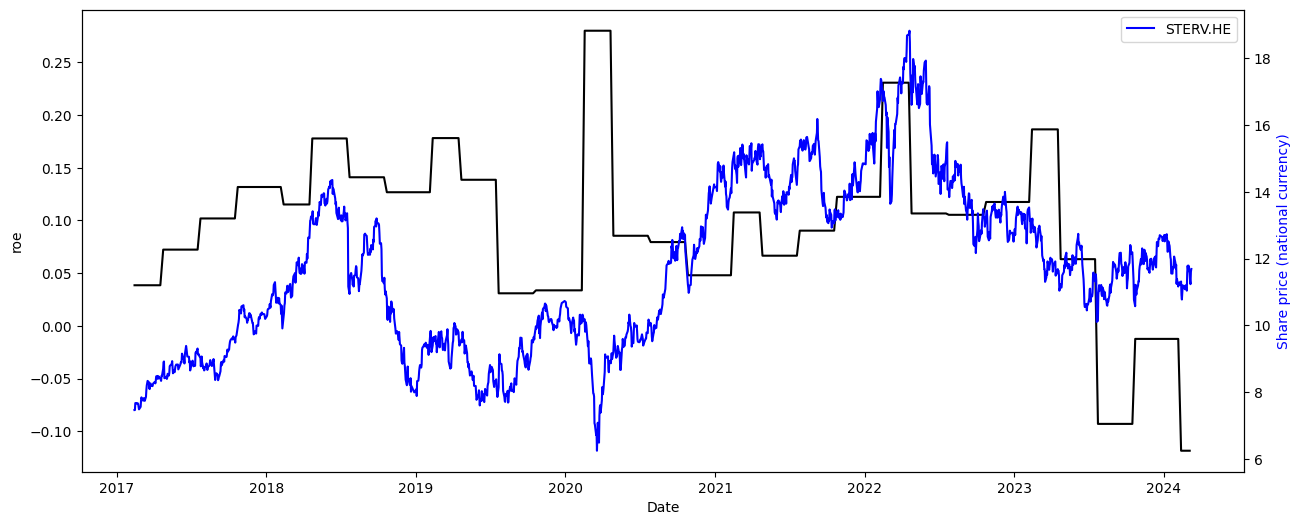

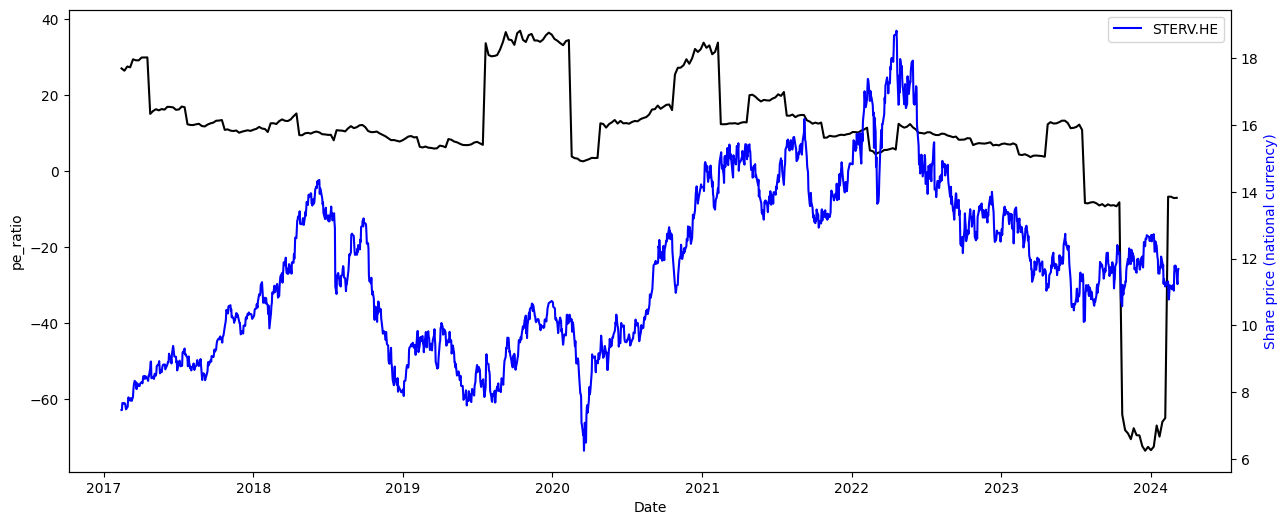

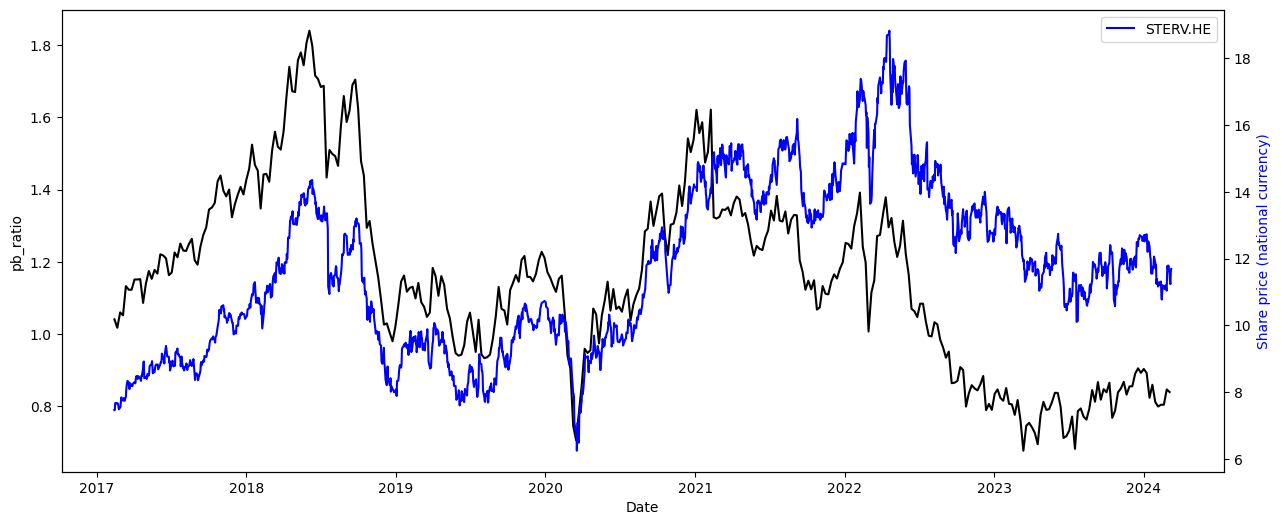

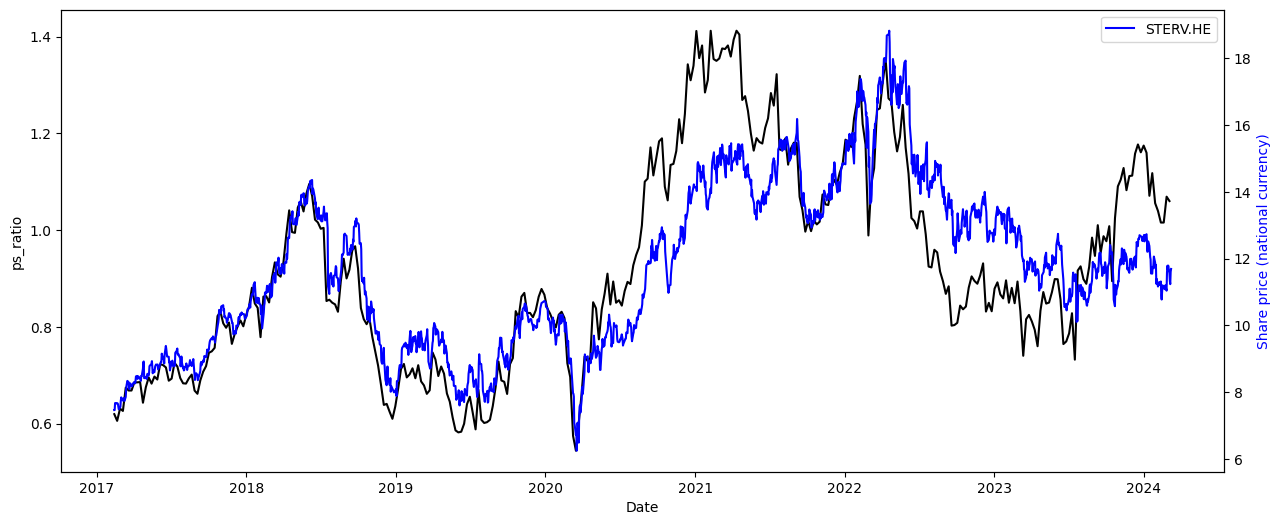

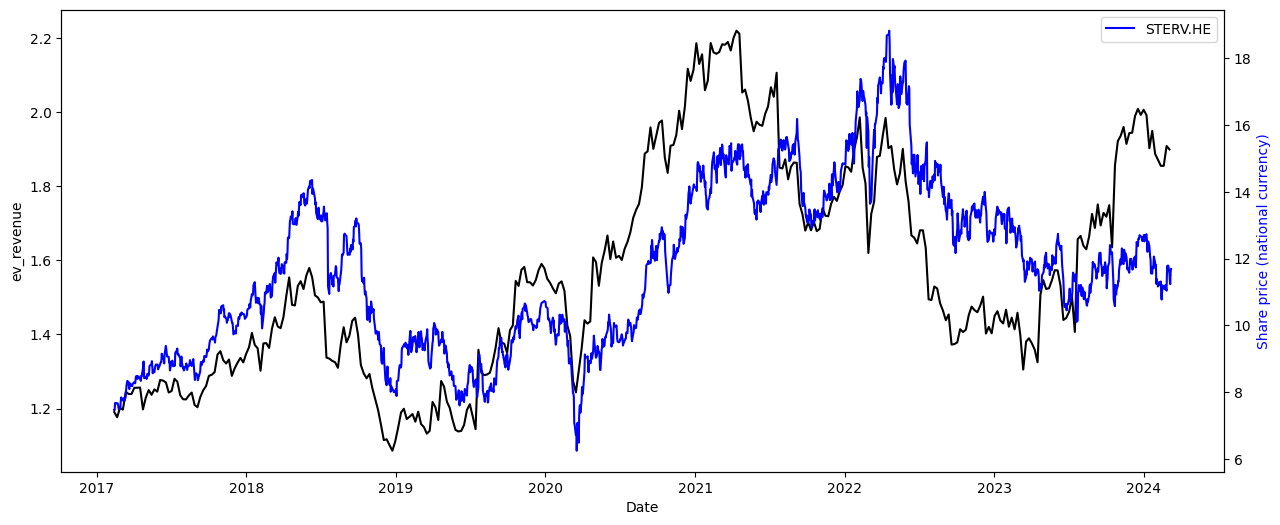

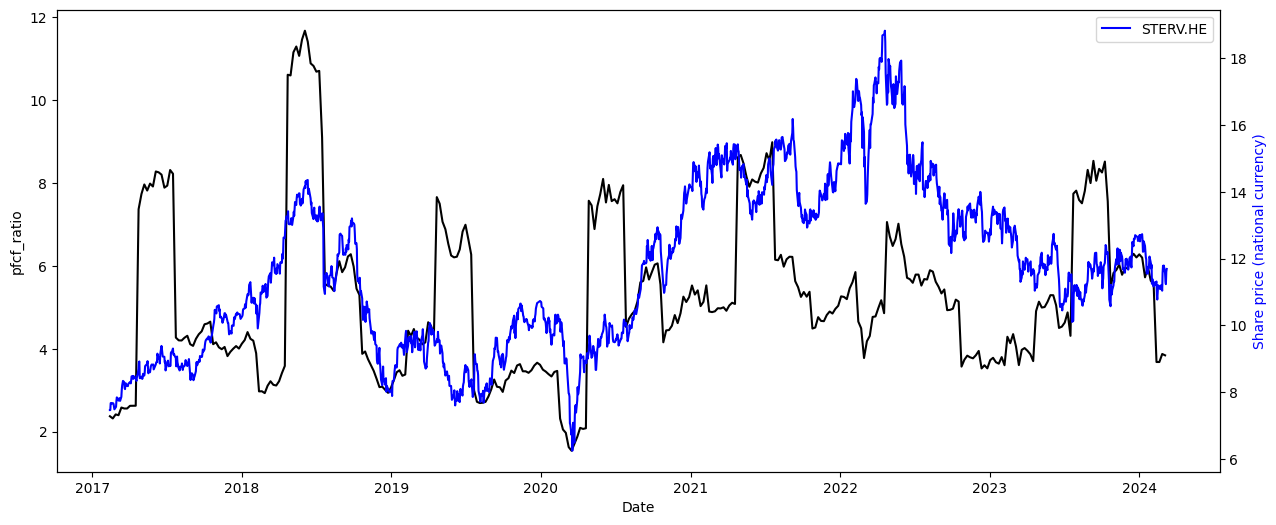

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

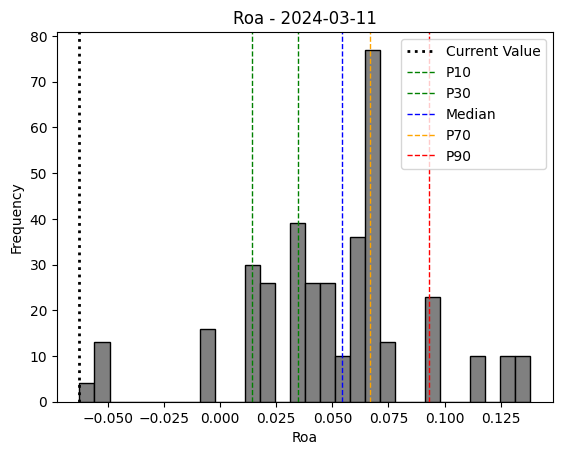

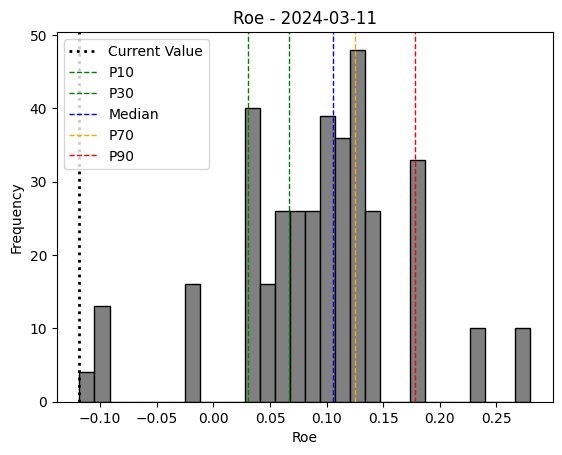

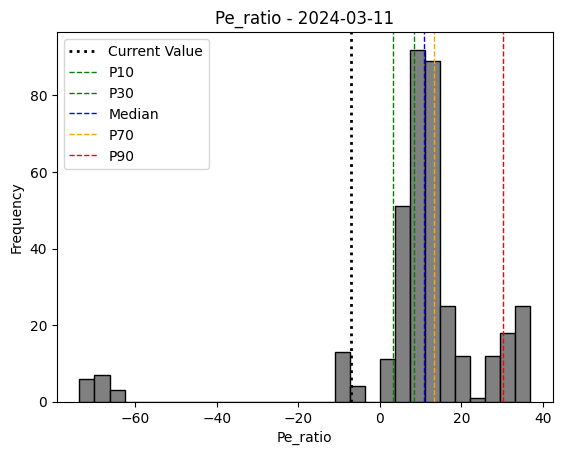

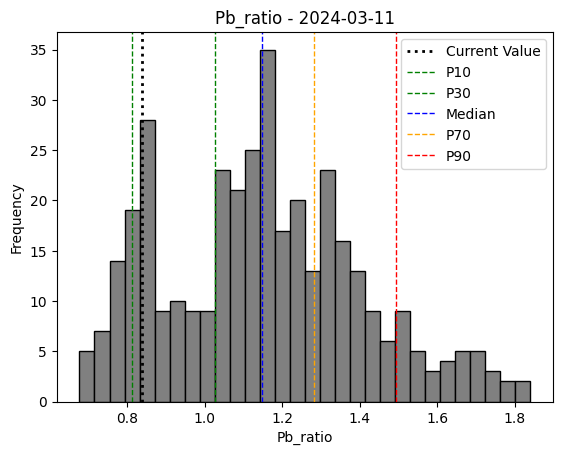

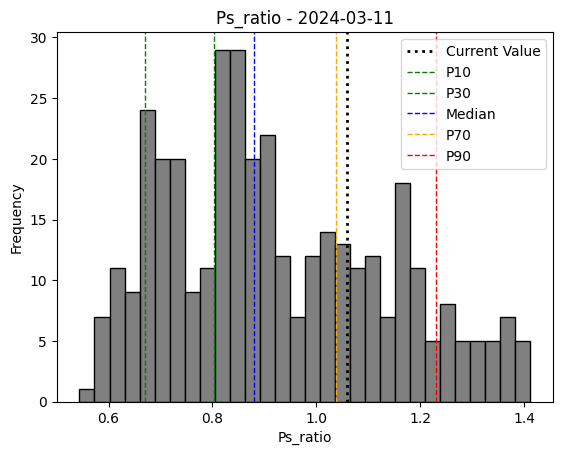

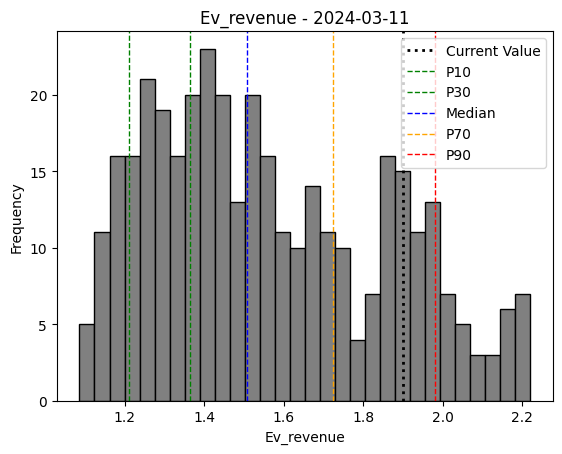

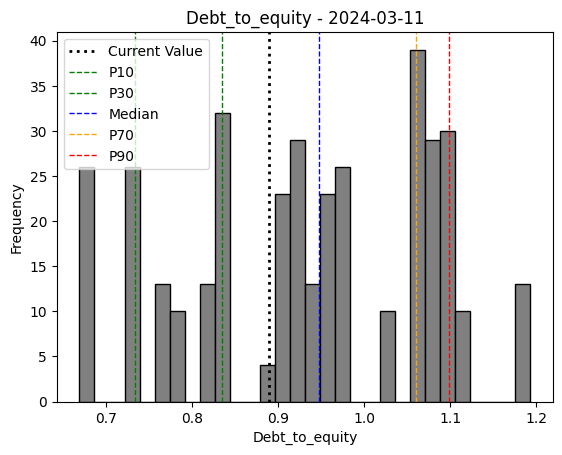

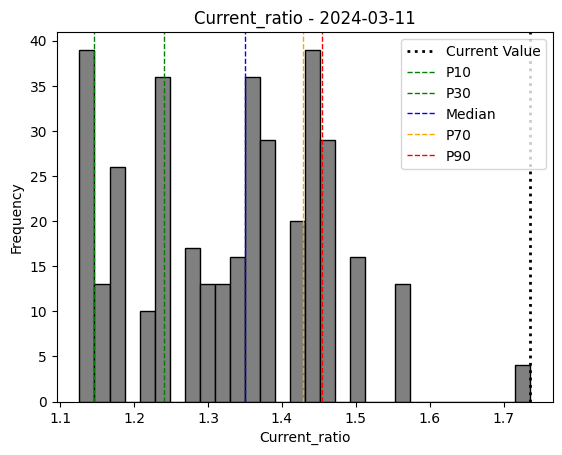

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.993735,0.156386,0.209756,-0.112940,-0.293423,-0.211904,-0.289206
roe,0.993735,1.000000,0.172230,0.251043,-0.140687,-0.312571,-0.123116,-0.330093
pe_ratio,0.156386,0.172230,1.000000,0.369767,-0.144890,-0.185994,0.446329,-0.408940
pb_ratio,0.209756,0.251043,0.369767,1.000000,0.357419,0.162670,0.395141,-0.411455
ps_ratio,-0.112940,-0.140687,-0.144890,0.357419,1.000000,0.946469,-0.252697,0.370268
ev_revenue,-0.293423,-0.312571,-0.185994,0.162670,0.946469,1.000000,-0.142344,0.439424
debt_to_equity,-0.211904,-0.123116,0.446329,0.395141,-0.252697,-0.142344,1.000000,-0.359041
current_ratio,-0.289206,-0.330093,-0.408940,-0.411455,0.370268,0.439424,-0.359041,1.000000


0 timestemos have been found!


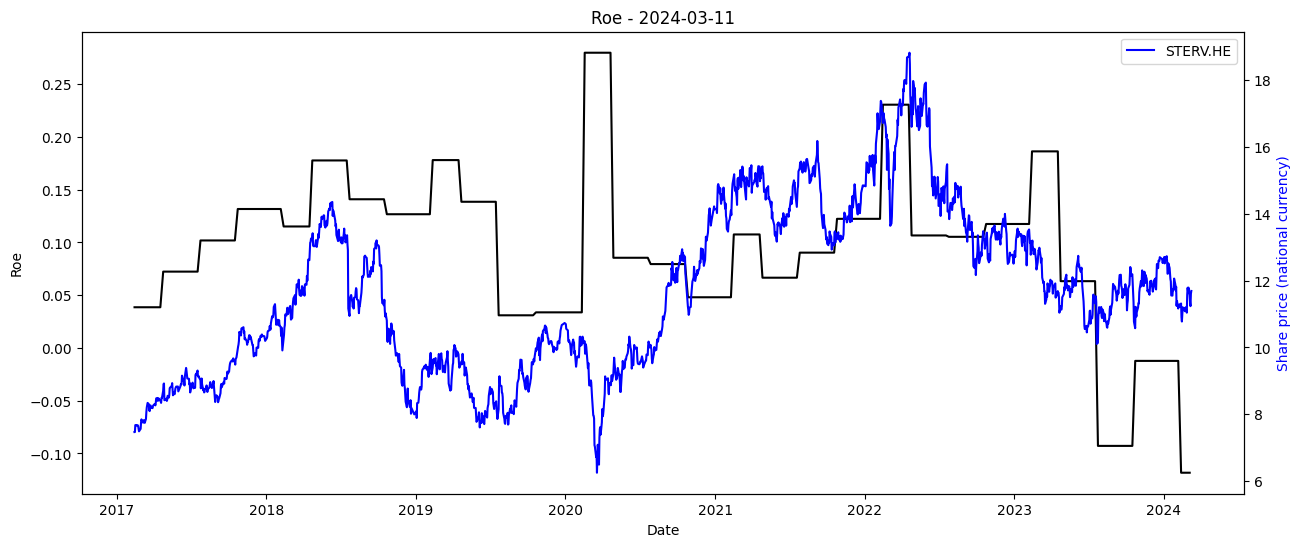

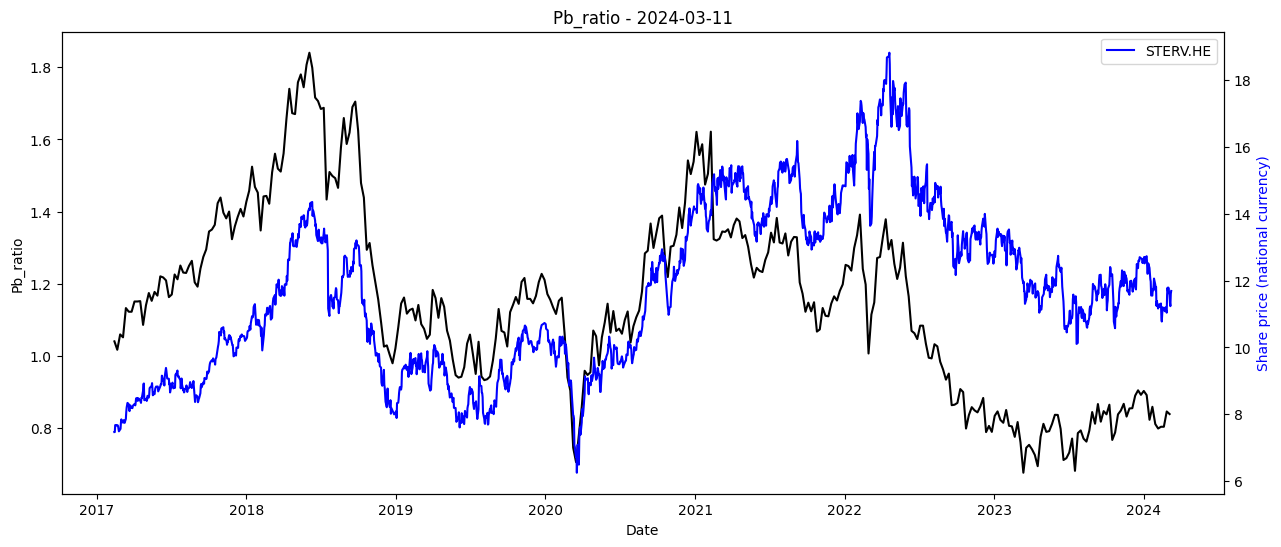

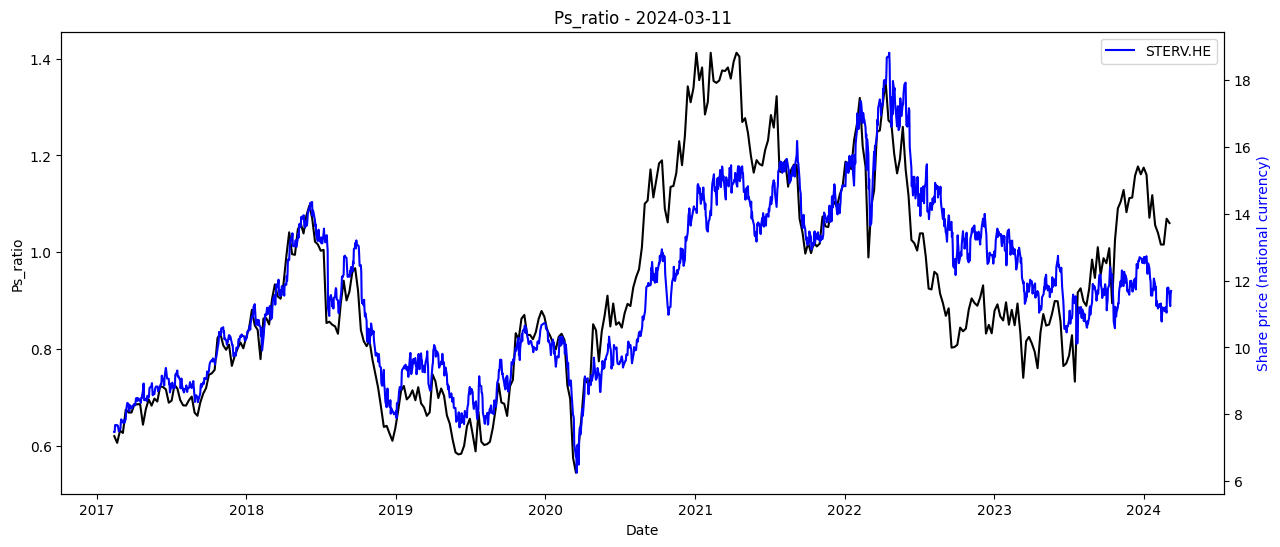

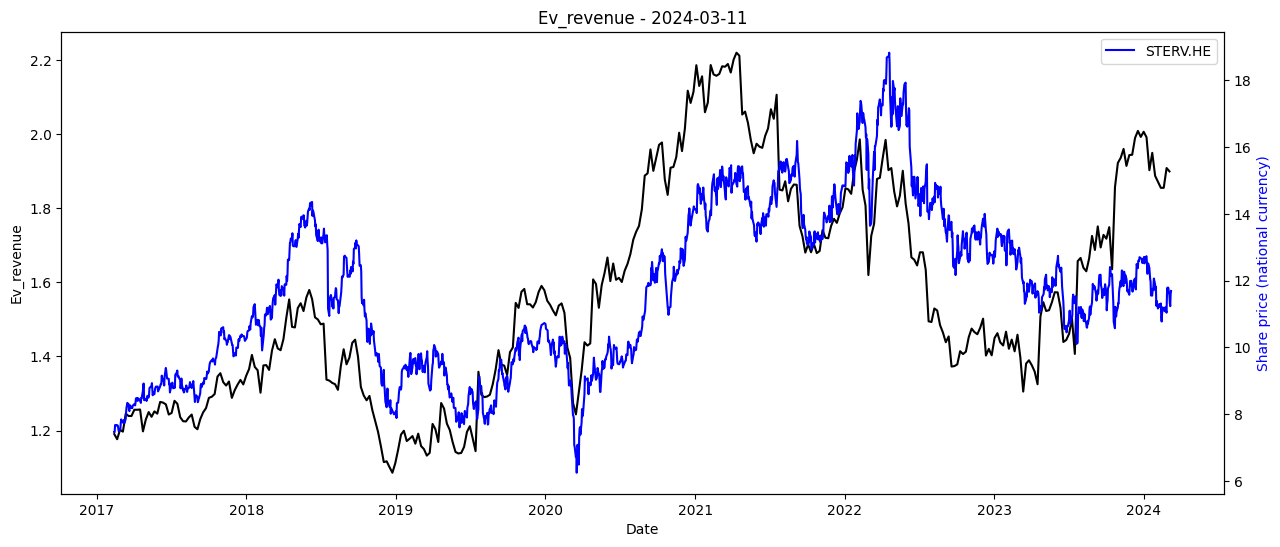

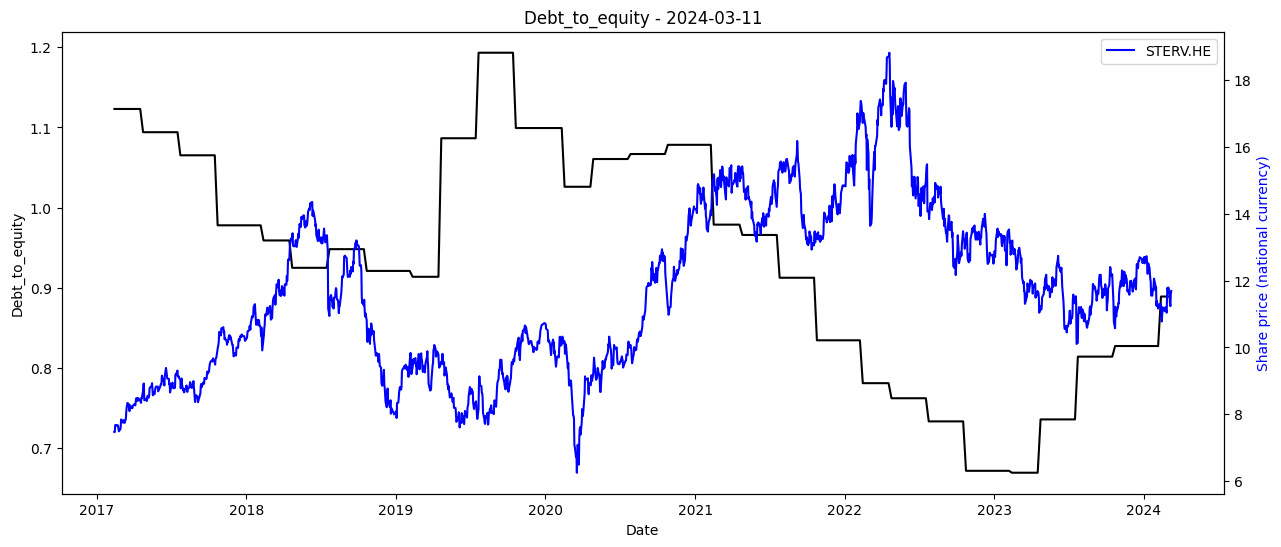

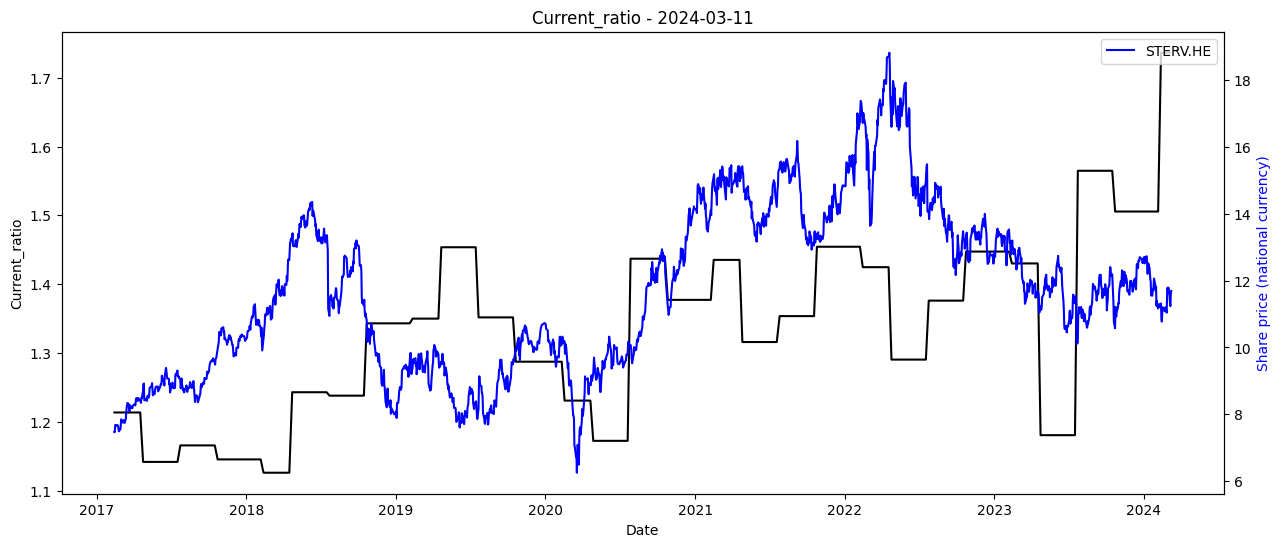

In [21]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )